In [1]:
import tensorflow as tf
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
import neurokit2 as nk
import shap
from scipy.ndimage import uniform_filter
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.madry_et_al import madry_et_al
from scipy.signal import butter, filtfilt, lfilter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

np.random.seed(42)

In [2]:
# Configuration
MODEL_PATH = "./model/model.keras"
RECORD_PATH = "./input/2767239" #Positive Chagas
#RECORD_PATH = "./input/14" #Negative Chagas
DATASET_DIR = '../GMC2025/code15_wfdb/'
REQUIRED_LENGTH = 1000
NUM_SAMPLES_TO_PLOT = 1
TARGET_FS = 100

In [3]:
def load_model(model_path):
    if not tf.io.gfile.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")
    
    model = tf.keras.models.load_model(model_path, compile=False)
    return model

In [4]:
def resample_signal(original_signal, original_fs, target_fs=100):
    if original_fs == target_fs:
        return original_signal
    fs_ratio = target_fs / original_fs
    return signal.resample(original_signal, int(original_signal.shape[0] * fs_ratio))

In [5]:
def adjust_signal_length(signal, target_length):
    """Pad or truncate signal to target length"""
    if signal.shape[0] < target_length:
        return np.pad(signal, ((0, target_length - signal.shape[0]), (0, 0)), mode='constant')
    return signal[:target_length]

In [6]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv1D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

In [7]:
def compute_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        
        
        class_output = preds[:, 0]
        class_idx = 1 if class_output > 0.5 else 0  # Threshold at 0.5
        
        grads = tape.gradient(class_output, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_output = conv_outputs[0] * pooled_grads

    heatmap = np.sum(conv_output.numpy(), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    
    return heatmap, class_idx

In [8]:
def plot_ecg_with_gradcam(signal, heatmap, lead_names, fs, class_idx):
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0]) / fs
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        vertical_offset = lead * 3
        ax.plot(time, signal[:, lead] + vertical_offset, linewidth=1, color='black')
        heatmap_extent = [time[0], time[-1], vertical_offset - 1.5, vertical_offset + 1.5]
        ax.imshow(
            np.expand_dims(heatmap_normalized, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=heatmap_extent,
            alpha=0.4,
            origin='lower'
        )
        ax.set_ylabel(lead_names[lead], rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_ylim(vertical_offset - 2, vertical_offset + 2)
        if lead != num_leads - 1:
            ax.set_xticks([])
    plt.suptitle(f"Predicted Class: {class_idx}\nGrad-CAM Heatmap Overlay", y=0.92)
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

In [9]:
#Helper
def get_header_file(record):
    if not record.endswith('.hea'):
        header_file = record + '.hea'
    else:
        header_file = record
    return header_file

def load_text(filename):
    with open(filename, 'r') as f:
        string = f.read()
    return string

def load_header(record):
    header_file = get_header_file(record)
    header = load_text(header_file)
    return header

def load_signals(record):
    signal, fields = wfdb.rdsamp(record)
    return signal, fields

def get_variable(string, variable_name):
    variable = ''
    has_variable = False
    for l in string.split('\n'):
        if l.startswith(variable_name):
            variable = l[len(variable_name):].strip()
            has_variable = True
    return variable, has_variable

def remove_extra_characters(x):
    x = str(x)
    x = x.replace('"', '').replace("'", "")
    x = x.replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('{', '').replace('}', '')
    x = x.replace(' ', '').replace('\t', '')
    x = x.strip()
    return x

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_number(x) and float(x)==0) or (remove_extra_characters(x).casefold() in ('false', 'f', 'no', 'n')):
        return 0
    elif (is_number(x) and float(x)==1) or (remove_extra_characters(x).casefold() in ('true', 't', 'yes', 'y')):
        return 1
    else:
        return float('nan')

def get_label(string, allow_missing=False):
    label, has_label = get_variable(string, label_string)
    if not has_label and not allow_missing:
        raise Exception('No label is available: are you trying to load the labels from the held-out data?')
    label = sanitize_boolean_value(label)
    return label

def load_label(record):
    header = load_header(record)
    label = get_label(header)
    return label

In [10]:
def get_chagas_label(text_extracted_from_signal):
    for comment in text_extracted_from_signal['comments']:
        if comment.startswith('Chagas label:'):
            label_str = comment.split(':')[-1].strip()  # Extract "False" or "True"
            break
    true_label = 1 if label_str == "True" else 0
    return true_label

In [11]:
model = load_model(MODEL_PATH)
ecg , text= load_signals(RECORD_PATH)

fs = int(text["fs"])
true_label = get_chagas_label(text)

conv_layer_name = find_last_conv_layer(model)
original_signal = ecg
original_fs = int(text["fs"])
if original_signal.ndim != 2 or original_signal.shape[1] != 12:
        raise ValueError("ECG signal must have shape (samples, 12 leads).")

Resampled samples: 733, Target FS: 100
Original Signal - Predicted Class: 1


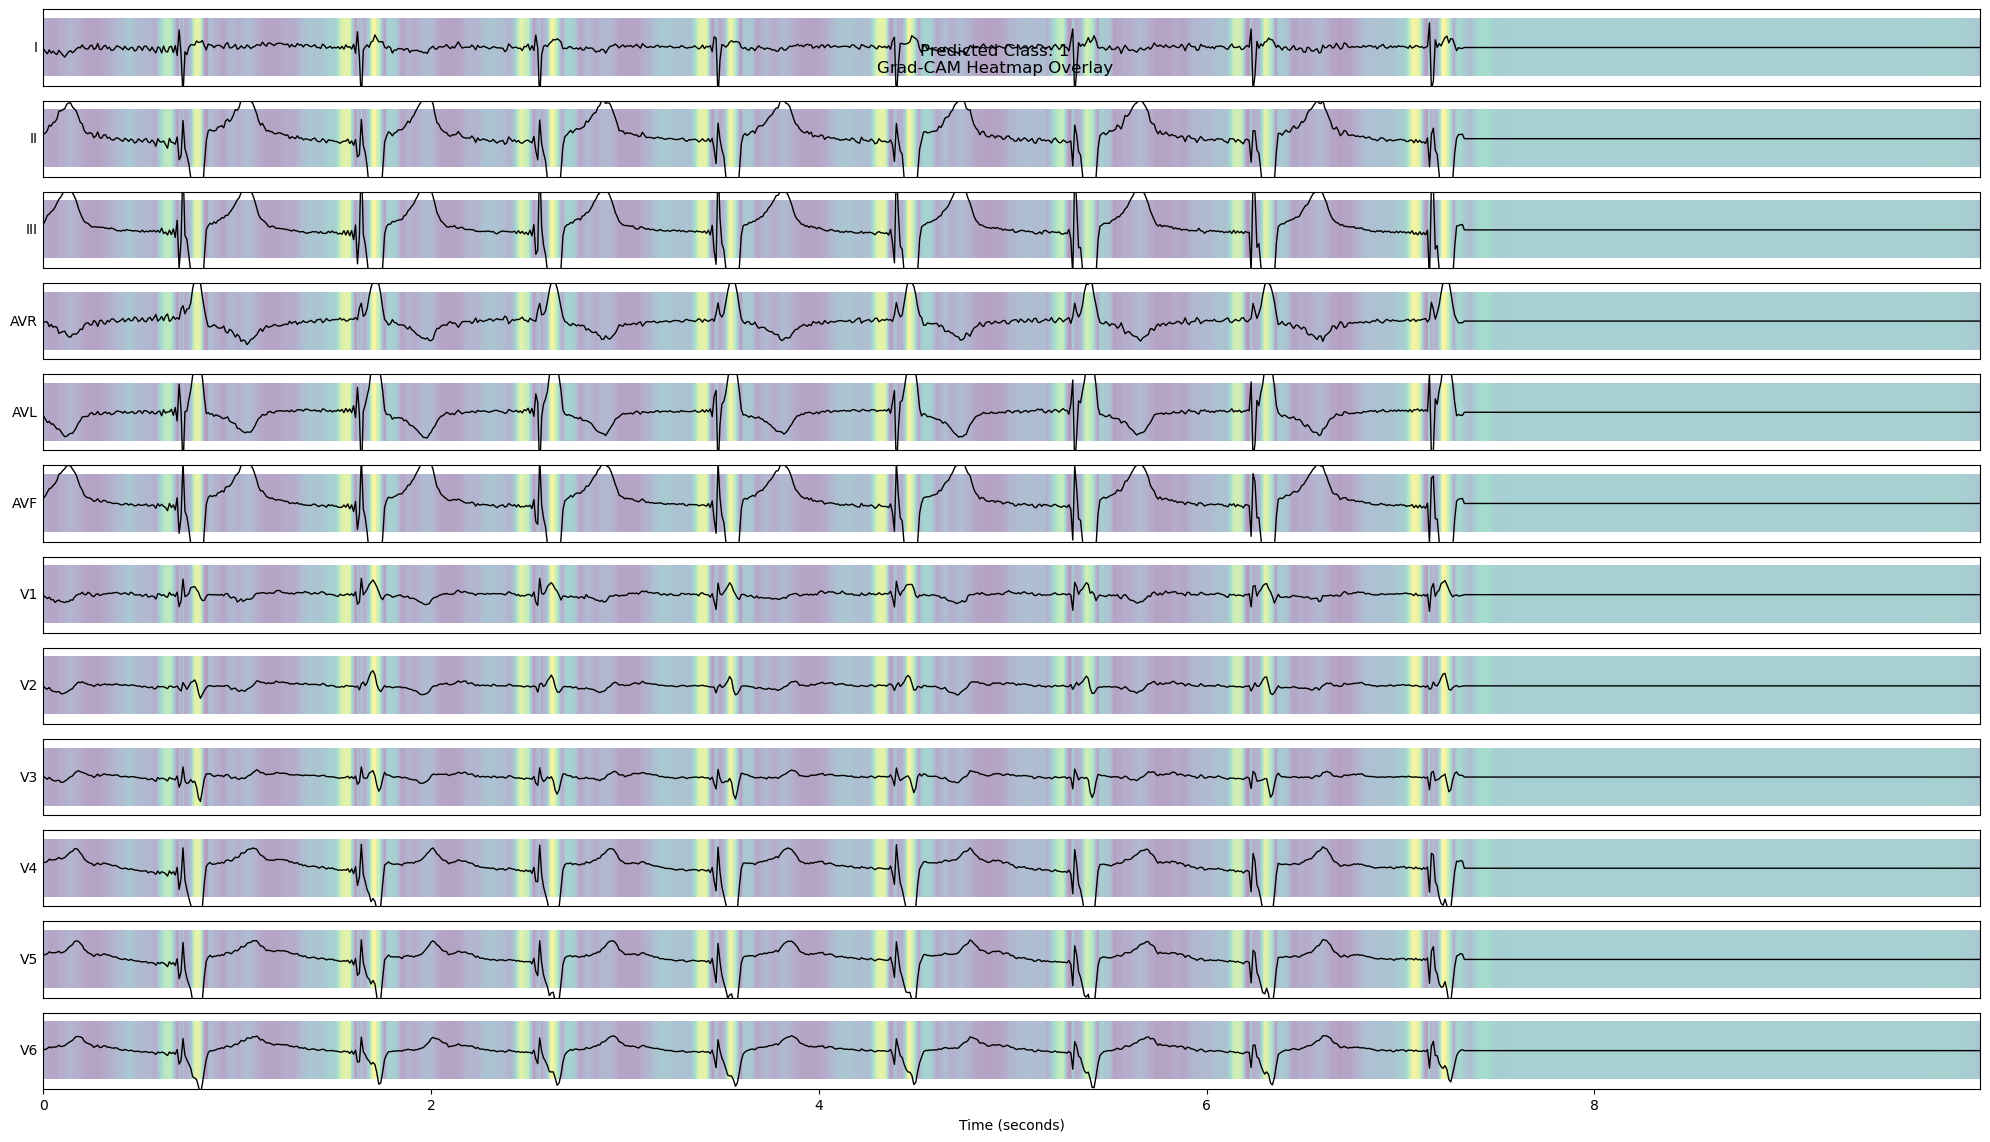

In [12]:
try:    
    # Resample and process signal
    resampled_signal = resample_signal(original_signal, original_fs, TARGET_FS)
    total_samples = resampled_signal.shape[0]
    
    print(f"Resampled samples: {total_samples}, Target FS: {TARGET_FS}")
    
    adjusted_signal = adjust_signal_length(resampled_signal, REQUIRED_LENGTH)
    
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(adjusted_signal, 0), dtype=tf.float32
    )
    
    # Compute Grad-CAM
    heatmap_original, class_idx_original = compute_grad_cam(model, input_tensor, conv_layer_name)
    
    # Plot Grad-CAM
    print(f"Original Signal - Predicted Class: {class_idx_original}")
    plot_ecg_with_gradcam(
        adjusted_signal,
        heatmap_original,
        text['sig_name'],
        TARGET_FS,
        class_idx=class_idx_original)
        
except Exception as main_error:
    print(f"Critical error: {str(main_error)}")

In [13]:
def load_all_records(dataset_path):
    records = set()  # to avoid duplicates

    for filename in os.listdir(dataset_path):
        if filename.endswith(".dat"):
            # Extract the record name (without the .dat extension)
            record_name = filename[:-4]
            records.add(record_name)

    sorted_record_names = sorted(records) # To make the same background using random seed
    
    return list(sorted_record_names)

In [14]:
def load_background_samples(dataset_path, num_samples=50):

    # Example: Load all records from the dataset
    records = load_all_records(dataset_path)  # Implement this function
    sampled_records = np.random.choice(records, num_samples, replace=False)

    background_samples = []
    
    for record in sampled_records:
        record_path = DATASET_DIR + record
        signal, _ = load_signals(record_path)  # Load ECG signal
        signal = preprocess_signal(signal)  # Preprocess (resample, adjust length, etc.)
        background_samples.append(signal)
    
    return np.array(background_samples)

In [15]:
def preprocess_signal(signal, target_length=1000, target_fs=100):

    # Resample to target frequency
    resampled_signal = resample_signal(signal, original_fs=signal.shape[0], target_fs=target_fs)

    processed_signal = adjust_signal_length(resampled_signal, target_length)
    
    return processed_signal

In [16]:
def compute_shap_explanations(model, adjusted_signal, lead_names, fs, class_idx):

    background_samples = load_background_samples(DATASET_DIR)
    background = background_samples
    
    explainer = shap.DeepExplainer(
        tf.keras.Model(inputs=model.input, outputs=model.output),
        background
    )
    shap_values = explainer.shap_values(adjusted_signal[np.newaxis, :, :])
    shap_heatmap = np.squeeze(shap_values[0])

    if shap_heatmap.ndim == 3:
        shap_heatmap = shap_heatmap.reshape(adjusted_signal.shape)

    shap_heatmap_normalized = np.zeros_like(shap_heatmap)
    for lead in range(12):
        lead_data = shap_heatmap[:, lead]
        normalized = (lead_data - np.min(lead_data)) / (np.ptp(lead_data) + 1e-8)
        shap_heatmap_normalized[:, lead] = normalized
    
    plot_ecg_with_shap(adjusted_signal, shap_heatmap_normalized, lead_names, fs, class_idx)

In [17]:
def plot_ecg_with_shap(signal, heatmap, lead_names, fs, class_idx):

    if heatmap.shape != signal.shape:
        raise ValueError(f"Heatmap shape {heatmap.shape} doesn't match signal {signal.shape}")
    
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0])/fs
    
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        offset = lead * 3
        ax.plot(time, signal[:, lead] + offset, 'k', lw=1)
        ax.imshow(np.expand_dims(heatmap[:, lead], 0),
                cmap='viridis',
                aspect='auto',
                extent=[time[0], time[-1], offset-2, offset+5],
                alpha=0.4,
                origin='lower')
        ax.set(ylabel=lead_names[lead], yticks=[], ylim=[offset-2, offset+2])
        ax.set_xticks([]) if lead != num_leads-1 else None
    
    plt.suptitle(f"Class {class_idx} - SHAP Values", y=0.95)
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 1000, 12))']
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(100, 1000, 12))']
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/ke

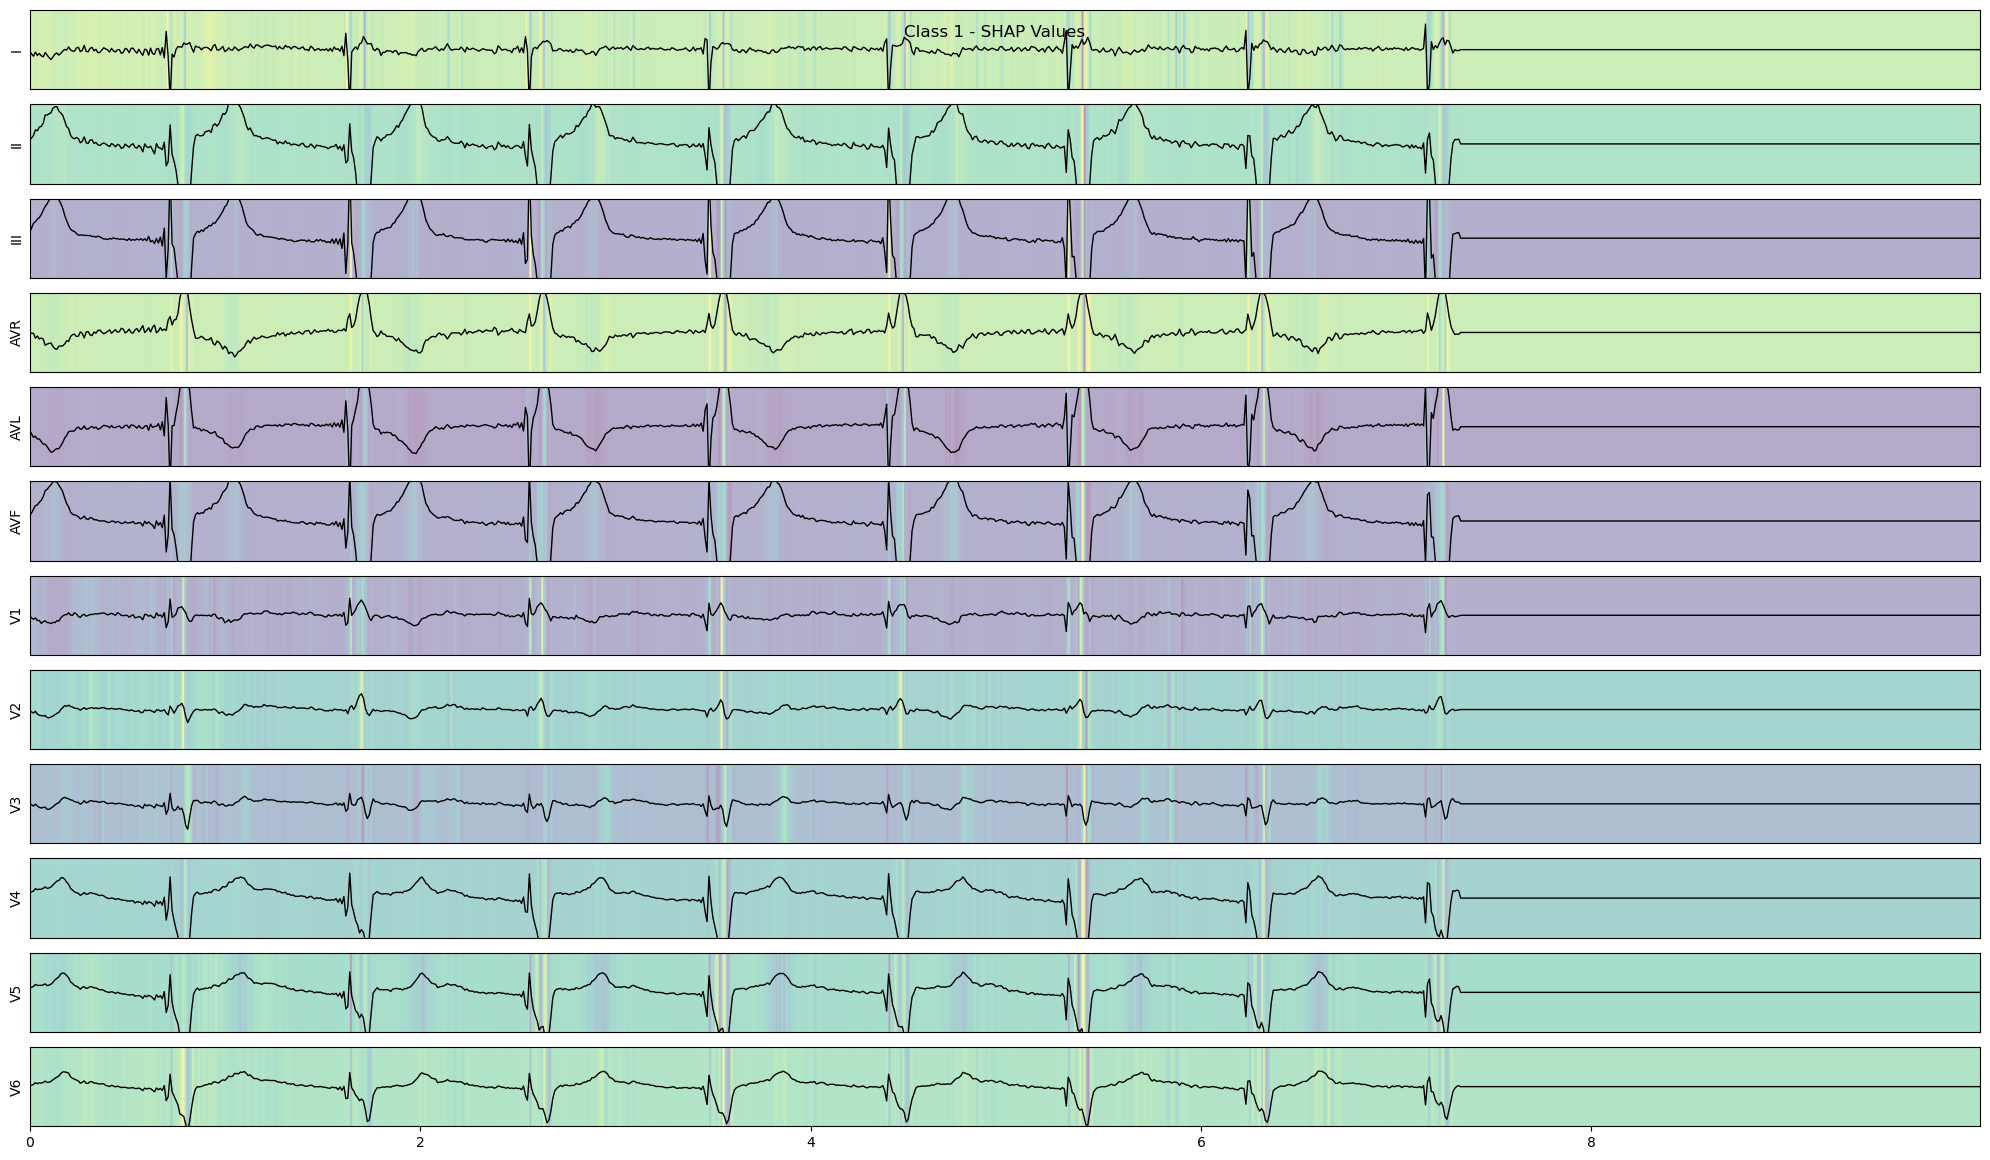

In [18]:
compute_shap_explanations(
    model=model,
    adjusted_signal=adjusted_signal,
    lead_names=text['sig_name'],
    fs=TARGET_FS,
    class_idx=class_idx_original
)

In [19]:
probability_output = model.predict(input_tensor)

print("Predicted probabilities:", probability_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Predicted probabilities: [[0.5230107]]


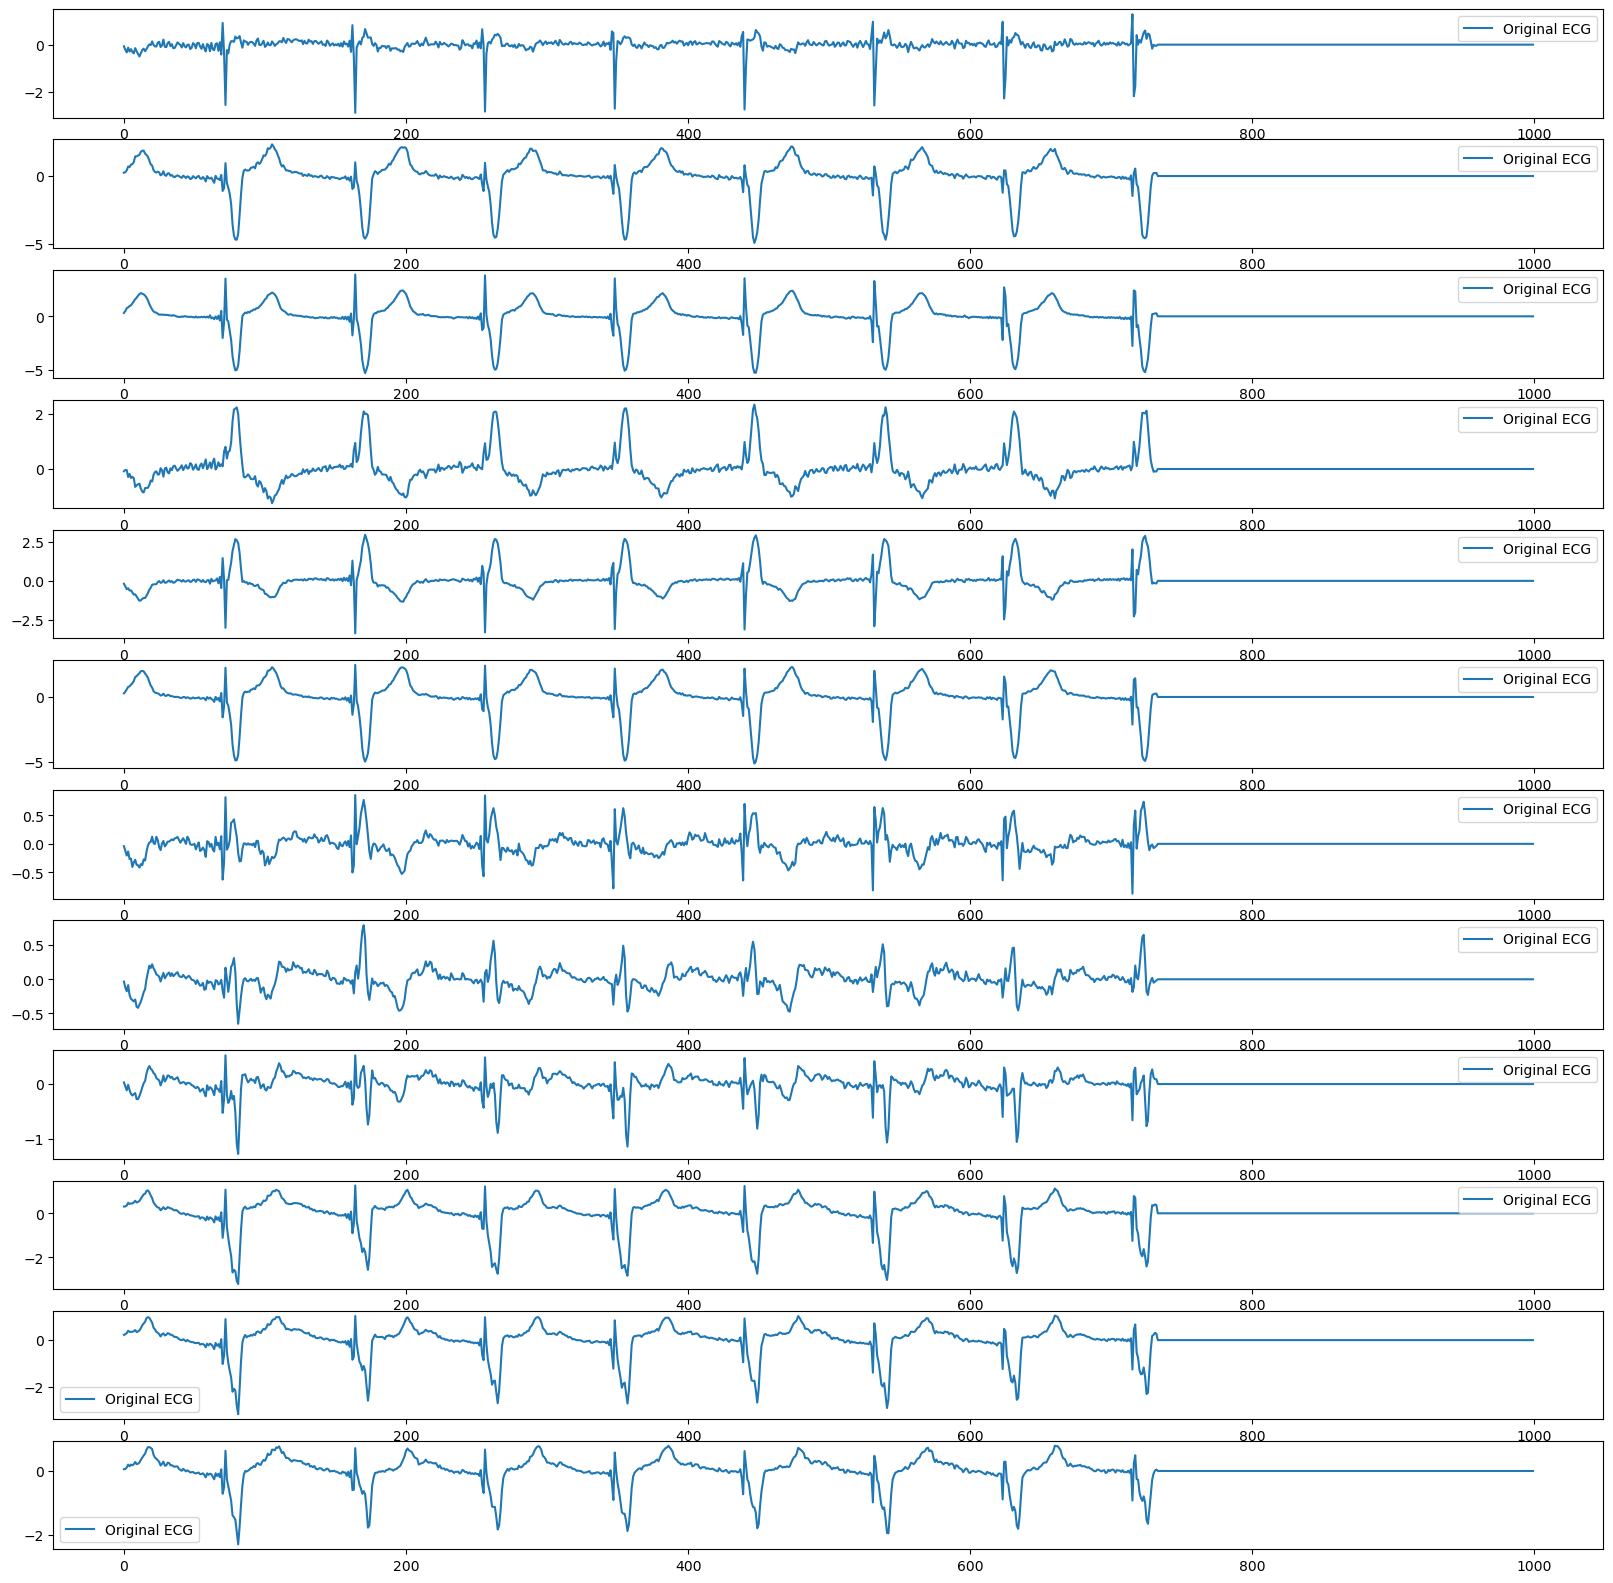

In [20]:
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(adjusted_signal)[:,i], label= "Original ECG")
    plt.legend()

In [21]:
def bandpass_filter(signal, lowcut=0.5, highcut=49.9, fs=100, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [22]:
def optimize_linear(grad, eps):

    axis = list(range(1, len(grad.get_shape())))
    avoid_zero_div = 1e-12

    # Take sign of gradient
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation = tf.multiply(eps, optimal_perturbation)
    
    return scaled_perturbation

In [23]:
max_iterations = 100
eps = 0.01
target_class = 1 - true_label   # Flip the label
adv_x = tf.identity(input_tensor)

clinical_threshold = 0.01

for iteration in range(max_iterations):
    current_prob = model.predict(adv_x)[0][0]
    print(current_prob)
    
    # Success criteria for probabilistic outputs
    if (target_class == 0 and current_prob < 0.1) or \
       (target_class == 1 and current_prob > 0.5):
        print(f"Success at iteration {iteration}: Prob={current_prob:.4f}")
        break

    # Gradient calculation
    with tf.GradientTape() as tape:
        tape.watch(adv_x)
        pred = model(adv_x)
        loss = tf.keras.losses.binary_crossentropy(
            tf.constant([[target_class]], dtype=tf.float32), 
            pred
        )
        loss = -loss  # Gradient ASCENT for adversarial attack

    grads = tape.gradient(loss, adv_x)
    perturbation = optimize_linear(grads, eps)
    
    # ECG-specific filtering
    perturbation_filtered = np.array([
        bandpass_filter(perturbation[0,:,i], fs=TARGET_FS, lowcut=0.5, highcut=49.9)
        for i in range(12)
    ])
    perturbation_filtered = np.expand_dims(perturbation_filtered.T, 0)

    adv_x = adv_x + perturbation_filtered
    adv_x = tf.clip_by_value(adv_x, np.min(adjusted_signal), np.max(adjusted_signal))  #ECG voltage range

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0.5230107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0.42175627
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.31590962
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.21893819
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.13988458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.08251533
Success at iteration 5: Prob=0.0825


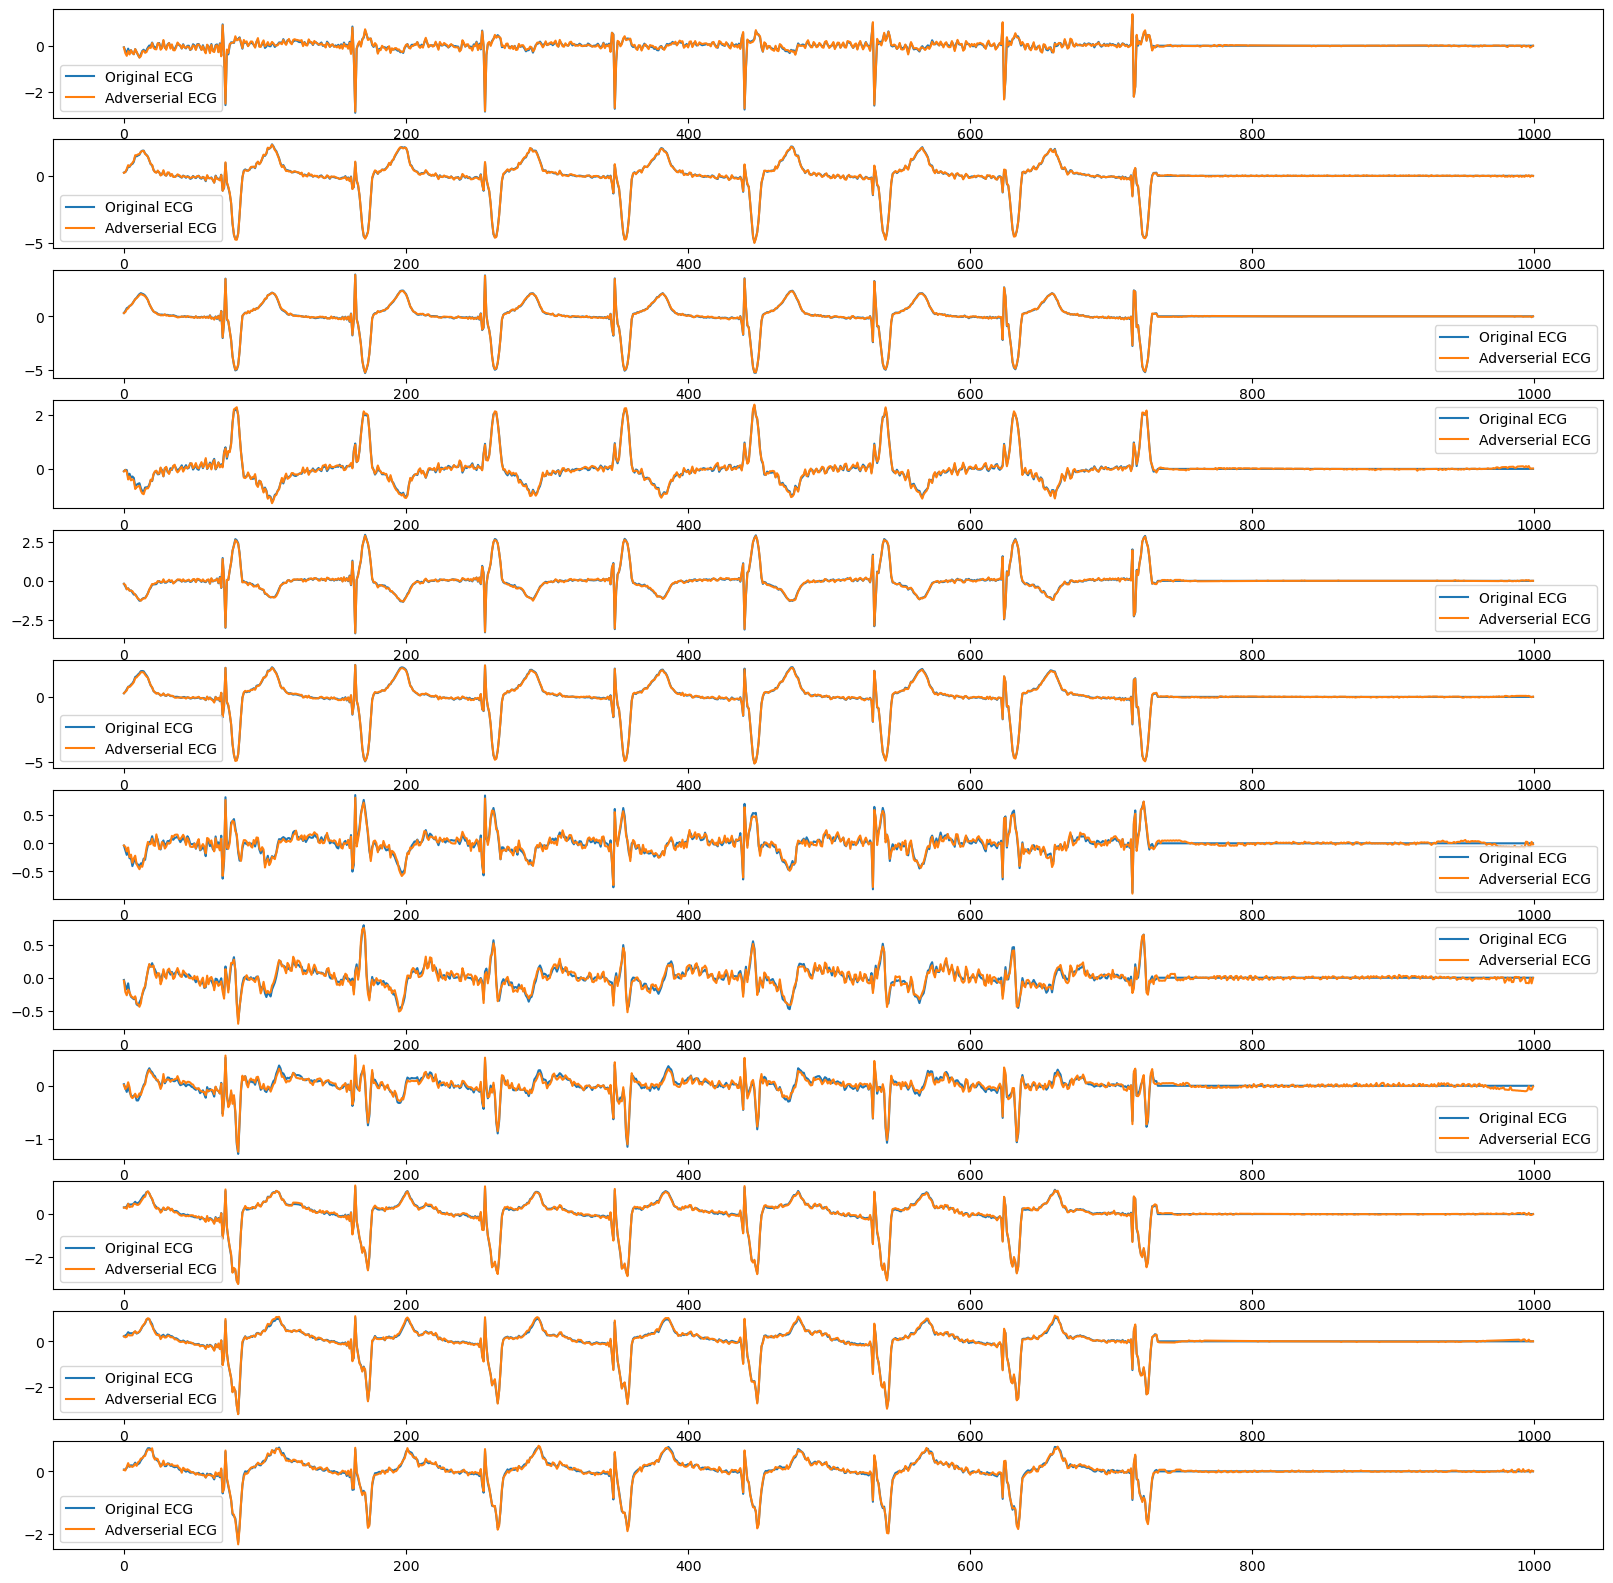

In [24]:
plt.figure(figsize=(20,20))
#adv_x = bandpass_filter(adv_x)
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.asarray(input_tensor)[0,:,i], label= "Original ECG")
    plt.plot(np.asarray(adv_x)[0,:,i], label= "Adverserial ECG")
    plt.legend()

In [25]:
original_pred = model.predict(input_tensor)
print("Original Prediction:", original_pred)
print(true_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Original Prediction: [[0.5230107]]
1


In [26]:
input_tensor.shape

TensorShape([1, 1000, 12])

In [27]:
model.input_shape

(None, 1000, 12)

In [28]:
original_pred

array([[0.5230107]], dtype=float32)

In [29]:
print(f"true_label: {true_label}, type: {type(true_label)}")

true_label: 1, type: <class 'int'>


In [30]:
# Define Model Wrapper
class ModelWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model  # Original model that outputs probabilities

    def call(self, x):
        probabilities = self.model(x)  # Model outputs probabilities
        eps = 1e-10  # Small value to prevent numerical instability
        logits = tf.math.log((probabilities + eps) / (1 - probabilities + eps))  # Convert to logits
        return logits

In [31]:
# Wrap the original model
wrapped_model = ModelWrapper(model)

In [32]:
original_output = model(input_tensor)
print("Original model output (probabilities):", original_output)


wrapped_output = wrapped_model(input_tensor)
print("Wrapped model output (logits):", wrapped_output)

Original model output (probabilities): tf.Tensor([[0.5230107]], shape=(1, 1), dtype=float32)
Wrapped model output (logits): tf.Tensor([[0.09210778]], shape=(1, 1), dtype=float32)


In [33]:
# Custom Binary Loss Function
def binary_loss(labels, logits):
    return tf.nn.sigmoid_cross_entropy_with_logits(
        labels=labels,  # Shape (1, 1)
        logits=logits   # Shape (1, 1)
    )

Gradient Norm: 0.003514011623337865
Difference between BIM and PGD adversarial examples: 66.681396484375


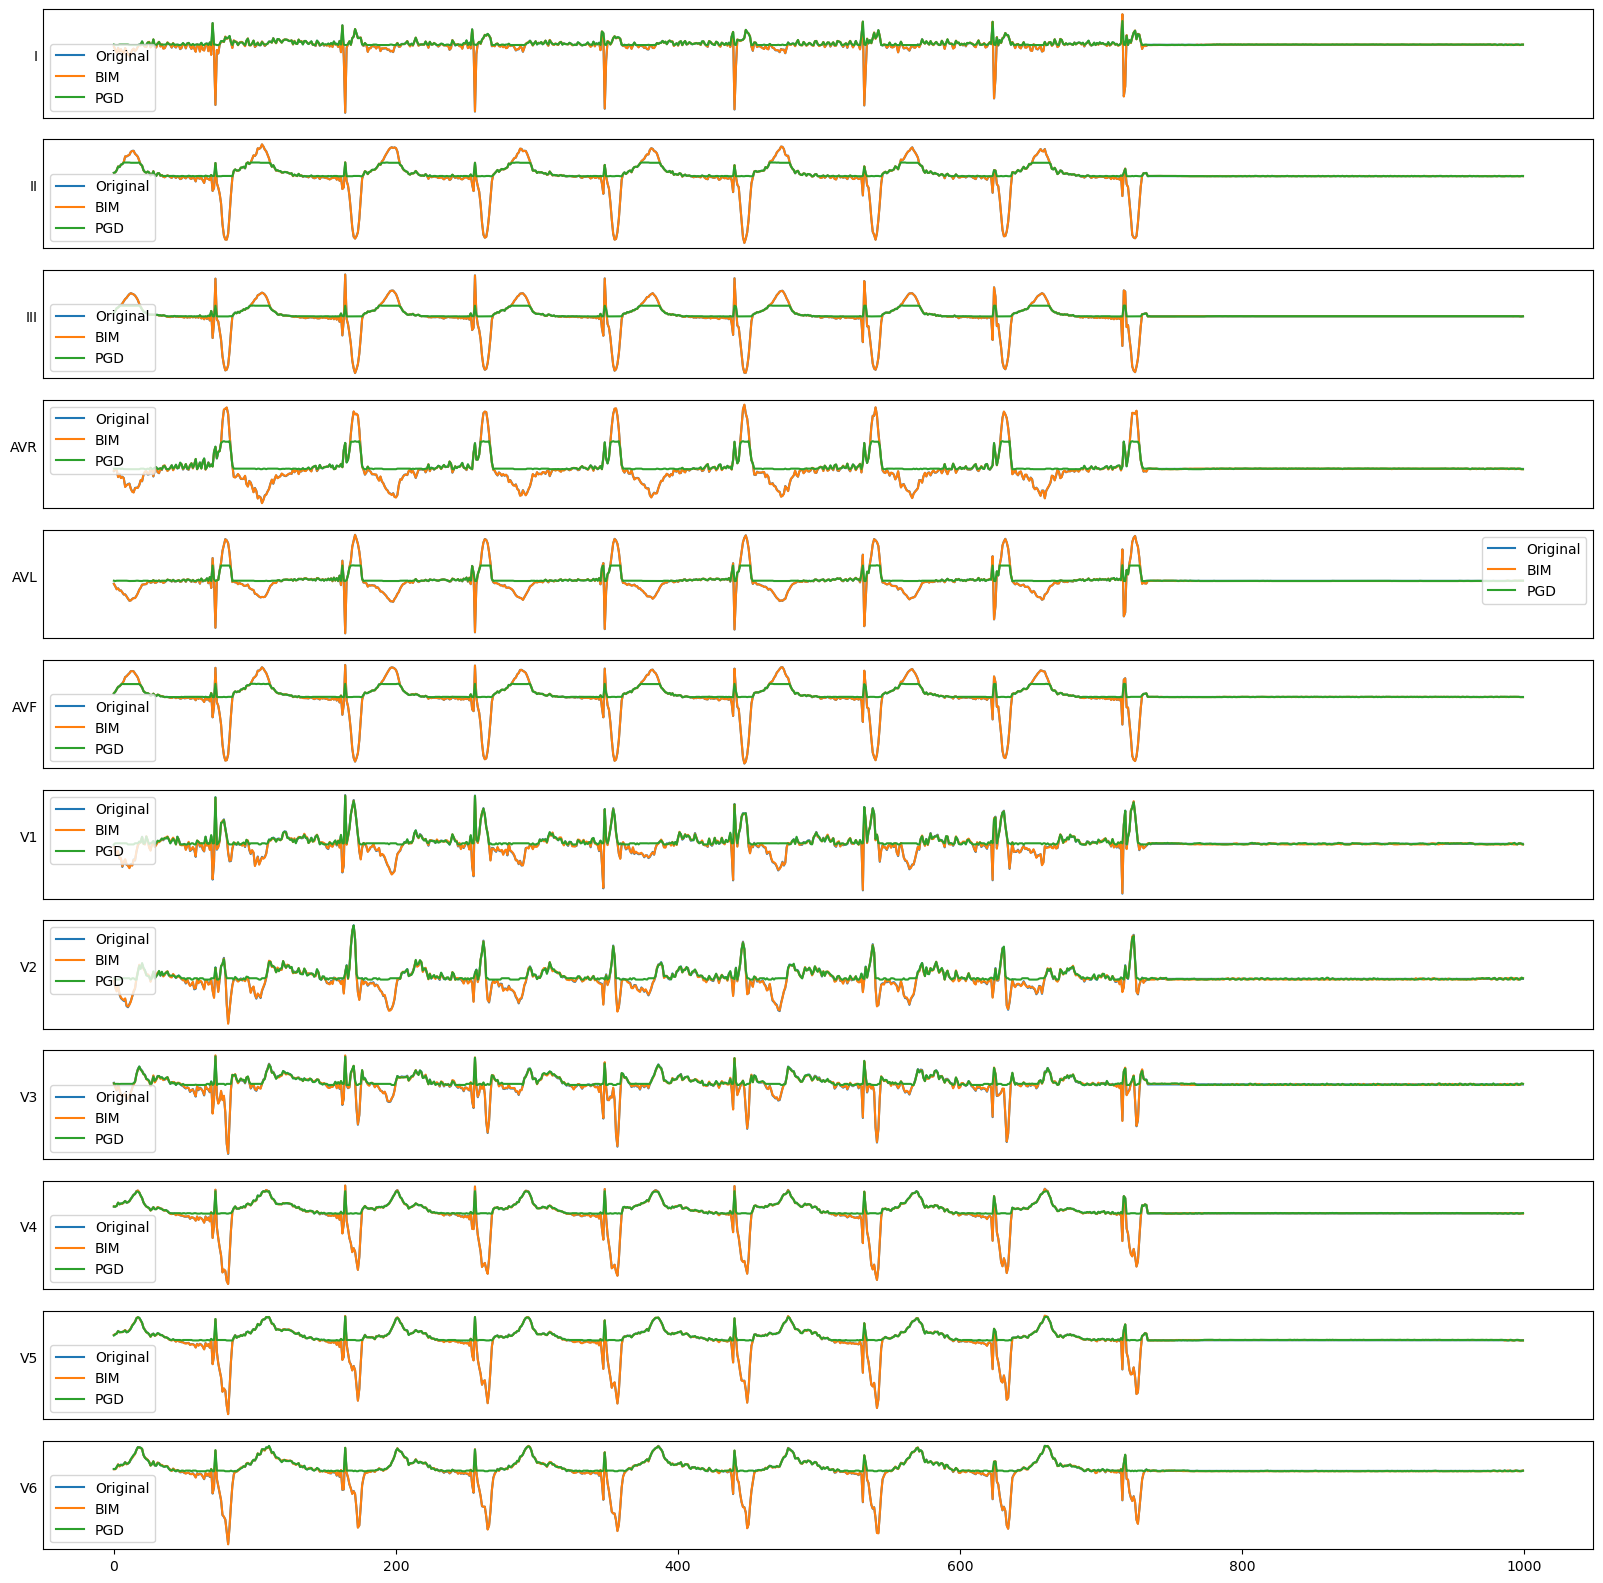

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Original: [[0.5230107]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
BIM: [[0.40209875]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PGD: [[0.02994658]]


In [34]:
# Attack parameters
true_label_tf = tf.constant([[true_label]], dtype=tf.float32)

eps = 0.01  # perturbation size
alpha = eps / 4  # step size
steps = 100  # attack steps

# Check gradient flow
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    logits = wrapped_model(input_tensor)
grads = tape.gradient(logits, input_tensor)
grad_norm = tf.reduce_mean(tf.abs(grads)).numpy()
print(f"Gradient Norm: {grad_norm}")  # Should not be too close to zero

if grad_norm < 1e-6:
    raise ValueError("Gradient vanishing! Check if the model is differentiable.")

# **Random Initialization for PGD**
random_noise = tf.random.uniform(shape=tf.shape(input_tensor), minval=-eps, maxval=eps)
pgd_input = tf.clip_by_value(input_tensor + random_noise, 0, 1)  # Ensure valid input range

# Generate adversarial examples
adv_bim = projected_gradient_descent(
    wrapped_model,  # Use wrapped model
    input_tensor,
    eps,
    alpha,
    steps,
    norm=np.inf,
    y=true_label_tf,
    loss_fn=binary_loss  # Use custom binary loss
)

adv_pgd = projected_gradient_descent(
    wrapped_model,  # Use wrapped model
    pgd_input,  # PGD starts from a randomly perturbed input
    eps,
    alpha,
    steps,
    norm=np.inf,
    y=true_label_tf,
    loss_fn=binary_loss  # Use custom binary loss
)

# Check if adversarial examples are different
diff = tf.norm(adv_bim - adv_pgd).numpy()
print(f"Difference between BIM and PGD adversarial examples: {diff}")

# Visualization
plt.figure(figsize=(20, 20))
for i in range(12):
    plt.subplot(12, 1, i+1)
    plt.plot(adjusted_signal[:, i], label="Original")
    plt.plot(adv_bim.numpy()[0, :, i], label="BIM")
    plt.plot(adv_pgd.numpy()[0, :, i], label="PGD")
    plt.ylabel(text['sig_name'][i], rotation=0, ha='right')
    plt.yticks([])
    if i != 11: plt.xticks([])
    plt.legend()
plt.show()

# Predictions
print("Original:", model.predict(input_tensor))
print("BIM:", model.predict(adv_bim))
print("PGD:", model.predict(adv_pgd))

Below this need to be try again

In [35]:
def extract_average_beat(signal_lead, sampling_rate):
    """Extract and average ECG beats using NeuroKit2."""
    cleaned = nk.ecg_clean(signal_lead, sampling_rate=sampling_rate)
    _, rpeaks = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate)
    
    if len(rpeaks["ECG_R_Peaks"]) == 0:
        raise ValueError("No R-peaks detected")
        
    segments = nk.ecg_segment(cleaned, rpeaks=rpeaks["ECG_R_Peaks"], sampling_rate=sampling_rate)
    
    # If only one segment exists, use it; otherwise, exclude 'Segment_0' (if needed)
    if len(segments) == 1:
        beat_keys = list(segments.keys())
    else:
        beat_keys = [k for k in segments.keys() if k != 'Segment_0']
    
    # Fallback: if filtering removes all keys, then use 'Segment_0'
    if not beat_keys:
        beat_keys = ['Segment_0']
    
    beats = [segments[k]["Signal"] for k in beat_keys]
    avg_beat = np.mean(beats, axis=0)
    return avg_beat

In [36]:
# Generate adversarial examples dictionary
attacks = {
    "bim": adv_bim,
    "pgd": adv_pgd
}

In [37]:
def find_best_lead(signal, sampling_rate):
    """Find lead with most detectable R-peaks"""
    max_peaks = -1
    best_lead = 0
    for lead in range(signal.shape[1]):
        try:
            non_zero_indices = np.where(signal[:, lead] != 0)[0]
            trimmed = signal[:non_zero_indices[-1]+1, lead]
            cleaned = nk.ecg_clean(trimmed, sampling_rate=sampling_rate)
            _, rpeaks = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate)
            if len(rpeaks["ECG_R_Peaks"]) > max_peaks:
                max_peaks = len(rpeaks["ECG_R_Peaks"])
                best_lead = lead
        except:
            continue
    return best_lead

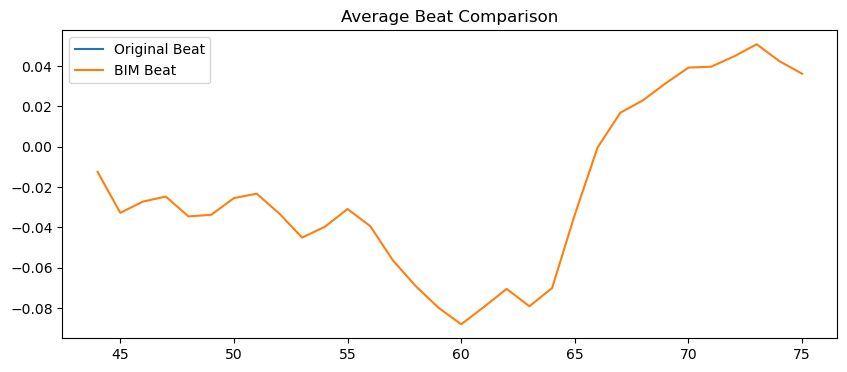

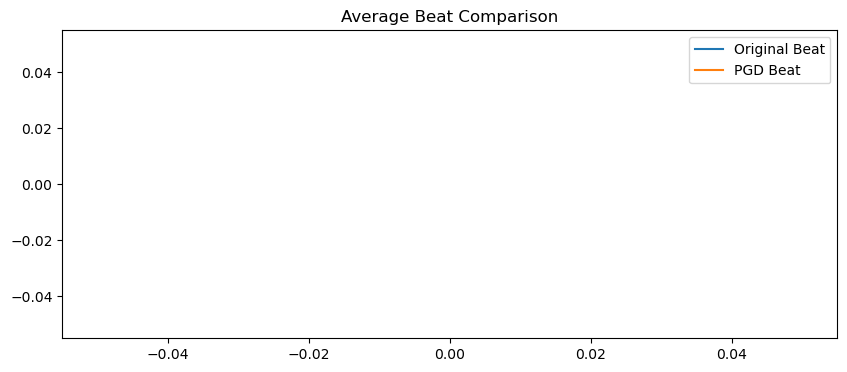

In [38]:
# Visualization and analysis
for name, adv_example in attacks.items():
    
    # Beat extraction and comparison
    try:
        best_lead = find_best_lead(adjusted_signal, TARGET_FS)
        
        orig_beat = extract_average_beat(adjusted_signal[:, best_lead], TARGET_FS)
        adv_beat = extract_average_beat(adv_example.numpy()[0, :, best_lead], TARGET_FS)
        
        plt.figure(figsize=(10, 4))
        plt.plot(orig_beat, label="Original Beat")
        plt.plot(adv_beat, label=f"{name.upper()} Beat")
        plt.title("Average Beat Comparison")
        plt.legend()
        plt.show()
        
    except ValueError as e:
        print(f"Beat comparison failed: {e}")